In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import time

In [3]:
#Adan: Adaptive Nesterov Momentum Algorithm

import math
from typing import List
from torch import Tensor

class MultiTensorApply(object):
    available = False
    warned = False

    def __init__(self, chunk_size):
        try:
            MultiTensorApply.available = True
            self.chunk_size = chunk_size
        except ImportError as err:
            MultiTensorApply.available = False
            MultiTensorApply.import_err = err

    def __call__(self, op, noop_flag_buffer, tensor_lists, *args):
        return op(self.chunk_size, noop_flag_buffer, tensor_lists, *args)


class Adan(torch.optim.Optimizer):
    """
    Implements a pytorch variant of Adan
    Adan was proposed in
    Adan: Adaptive Nesterov Momentum Algorithm for
        Faster Optimizing Deep Models[J].arXiv preprint arXiv:2208.06677, 2022.
    https://arxiv.org/abs/2208.06677
    Arguments:
        params (iterable): iterable of parameters to optimize or
            dicts defining parameter groups.
        lr (float, optional): learning rate. (default: 1e-3)
        betas (Tuple[float, float, flot], optional): coefficients used for
            first- and second-order moments. (default: (0.98, 0.92, 0.99))
        eps (float, optional): term added to the denominator to improve
            numerical stability. (default: 1e-8)
        weight_decay (float, optional): decoupled weight decay
            (L2 penalty) (default: 0)
        max_grad_norm (float, optional): value used to clip
            global grad norm (default: 0.0 no clip)
        no_prox (bool): how to perform the decoupled weight decay
            (default: False)
        foreach (bool): if True would use torch._foreach implementation.
            It's faster but uses slightly more memory. (default: True)
        fused (bool, optional): whether fused implementation is used.
            (default: False)
    """
    def __init__(self,
                 params,
                 lr=1e-3,
                 betas=(0.98, 0.92, 0.99),
                 eps=1e-8,
                 weight_decay=0.0,
                 max_grad_norm=0.0,
                 no_prox=False,
                 foreach: bool = True,
                 fused: bool = False):
        if not 0.0 <= max_grad_norm:
            raise ValueError('Invalid Max grad norm: {}'.format(max_grad_norm))
        if not 0.0 <= lr:
            raise ValueError('Invalid learning rate: {}'.format(lr))
        if not 0.0 <= eps:
            raise ValueError('Invalid epsilon value: {}'.format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError('Invalid beta parameter at index 0: {}'.format(
                betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError('Invalid beta parameter at index 1: {}'.format(
                betas[1]))
        if not 0.0 <= betas[2] < 1.0:
            raise ValueError('Invalid beta parameter at index 2: {}'.format(
                betas[2]))
        if fused:
            _check_fused_available()

        defaults = dict(lr=lr,
                        betas=betas,
                        eps=eps,
                        weight_decay=weight_decay,
                        max_grad_norm=max_grad_norm,
                        no_prox=no_prox,
                        foreach=foreach,
                        fused=fused)
        super().__init__(params, defaults)

    def __setstate__(self, state):
        super(Adan, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('no_prox', False)

    @torch.no_grad()
    def restart_opt(self):
        for group in self.param_groups:
            group['step'] = 0
            for p in group['params']:
                if p.requires_grad:
                    state = self.state[p]
                    # State initialization

                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(p)
                    # Exponential moving average of gradient difference
                    state['exp_avg_diff'] = torch.zeros_like(p)

    @torch.no_grad()
    def step(self, closure=None):
        """Performs a single optimization step."""

        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        if self.defaults['max_grad_norm'] > 0:
            device = self.param_groups[0]['params'][0].device
            global_grad_norm = torch.zeros(1, device=device)

            max_grad_norm = torch.tensor(self.defaults['max_grad_norm'],
                                         device=device)
            for group in self.param_groups:

                for p in group['params']:
                    if p.grad is not None:
                        grad = p.grad
                        global_grad_norm.add_(grad.pow(2).sum())

            global_grad_norm = torch.sqrt(global_grad_norm)

            clip_global_grad_norm = torch.clamp(
                max_grad_norm / (global_grad_norm + group['eps']),
                max=1.0).item()
        else:
            clip_global_grad_norm = 1.0

        for group in self.param_groups:
            params_with_grad = []
            grads = []
            exp_avgs = []
            exp_avg_sqs = []
            exp_avg_diffs = []
            neg_pre_grads = []

            beta1, beta2, beta3 = group['betas']
            # assume same step across group now to simplify things
            # per parameter step can be easily support
            # by making it tensor, or pass list into kernel
            if 'step' in group:
                group['step'] += 1
            else:
                group['step'] = 1

            bias_correction1 = 1.0 - beta1**group['step']
            bias_correction2 = 1.0 - beta2**group['step']
            bias_correction3 = 1.0 - beta3**group['step']

            for p in group['params']:
                if p.grad is None:
                    continue
                params_with_grad.append(p)
                grads.append(p.grad)

                state = self.state[p]
                if len(state) == 0:
                    state['exp_avg'] = torch.zeros_like(p)
                    state['exp_avg_sq'] = torch.zeros_like(p)
                    state['exp_avg_diff'] = torch.zeros_like(p)

                if 'neg_pre_grad' not in state or group['step'] == 1:
                    state['neg_pre_grad'] = p.grad.clone().mul_(
                        -clip_global_grad_norm)

                exp_avgs.append(state['exp_avg'])
                exp_avg_sqs.append(state['exp_avg_sq'])
                exp_avg_diffs.append(state['exp_avg_diff'])
                neg_pre_grads.append(state['neg_pre_grad'])

            if not params_with_grad:
                continue

            kwargs = dict(
                params=params_with_grad,
                grads=grads,
                exp_avgs=exp_avgs,
                exp_avg_sqs=exp_avg_sqs,
                exp_avg_diffs=exp_avg_diffs,
                neg_pre_grads=neg_pre_grads,
                beta1=beta1,
                beta2=beta2,
                beta3=beta3,
                bias_correction1=bias_correction1,
                bias_correction2=bias_correction2,
                bias_correction3_sqrt=math.sqrt(bias_correction3),
                lr=group['lr'],
                weight_decay=group['weight_decay'],
                eps=group['eps'],
                no_prox=group['no_prox'],
                clip_global_grad_norm=clip_global_grad_norm,
            )

            if group['foreach']:
                if group['fused']:
                    if torch.cuda.is_available():
                        _fused_adan_multi_tensor(**kwargs)
                    else:
                        raise ValueError('Fused Adan does not support CPU')
                else:
                    _multi_tensor_adan(**kwargs)
            elif group['fused']:
                if torch.cuda.is_available():
                    _fused_adan_single_tensor(**kwargs)
                else:
                    raise ValueError('Fused Adan does not support CPU')
            else:
                _single_tensor_adan(**kwargs)

        return loss


def _single_tensor_adan(
    params: List[Tensor],
    grads: List[Tensor],
    exp_avgs: List[Tensor],
    exp_avg_sqs: List[Tensor],
    exp_avg_diffs: List[Tensor],
    neg_pre_grads: List[Tensor],
    *,
    beta1: float,
    beta2: float,
    beta3: float,
    bias_correction1: float,
    bias_correction2: float,
    bias_correction3_sqrt: float,
    lr: float,
    weight_decay: float,
    eps: float,
    no_prox: bool,
    clip_global_grad_norm: Tensor,
):
    for i, param in enumerate(params):
        grad = grads[i]
        exp_avg = exp_avgs[i]
        exp_avg_sq = exp_avg_sqs[i]
        exp_avg_diff = exp_avg_diffs[i]
        neg_grad_or_diff = neg_pre_grads[i]

        grad.mul_(clip_global_grad_norm)

        # for memory saving, we use `neg_grad_or_diff`
        # to get some temp variable in a inplace way
        neg_grad_or_diff.add_(grad)

        exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)  # m_t
        exp_avg_diff.mul_(beta2).add_(neg_grad_or_diff,
                                      alpha=1 - beta2)  # diff_t

        neg_grad_or_diff.mul_(beta2).add_(grad)
        exp_avg_sq.mul_(beta3).addcmul_(neg_grad_or_diff,
                                        neg_grad_or_diff,
                                        value=1 - beta3)  # n_t

        denom = ((exp_avg_sq).sqrt() / bias_correction3_sqrt).add_(eps)
        step_size_diff = lr * beta2 / bias_correction2
        step_size = lr / bias_correction1

        if no_prox:
            param.mul_(1 - lr * weight_decay)
            param.addcdiv_(exp_avg, denom, value=-step_size)
            param.addcdiv_(exp_avg_diff, denom, value=-step_size_diff)
        else:
            param.addcdiv_(exp_avg, denom, value=-step_size)
            param.addcdiv_(exp_avg_diff, denom, value=-step_size_diff)
            param.div_(1 + lr * weight_decay)

        neg_grad_or_diff.zero_().add_(grad, alpha=-1.0)


def _multi_tensor_adan(
    params: List[Tensor],
    grads: List[Tensor],
    exp_avgs: List[Tensor],
    exp_avg_sqs: List[Tensor],
    exp_avg_diffs: List[Tensor],
    neg_pre_grads: List[Tensor],
    *,
    beta1: float,
    beta2: float,
    beta3: float,
    bias_correction1: float,
    bias_correction2: float,
    bias_correction3_sqrt: float,
    lr: float,
    weight_decay: float,
    eps: float,
    no_prox: bool,
    clip_global_grad_norm: Tensor,
):
    if len(params) == 0:
        return

    torch._foreach_mul_(grads, clip_global_grad_norm)

    # for memory saving, we use `neg_pre_grads`
    # to get some temp variable in a inplace way
    torch._foreach_add_(neg_pre_grads, grads)

    torch._foreach_mul_(exp_avgs, beta1)
    torch._foreach_add_(exp_avgs, grads, alpha=1 - beta1)  # m_t

    torch._foreach_mul_(exp_avg_diffs, beta2)
    torch._foreach_add_(exp_avg_diffs, neg_pre_grads,
                        alpha=1 - beta2)  # diff_t

    torch._foreach_mul_(neg_pre_grads, beta2)
    torch._foreach_add_(neg_pre_grads, grads)
    torch._foreach_mul_(exp_avg_sqs, beta3)
    torch._foreach_addcmul_(exp_avg_sqs,
                            neg_pre_grads,
                            neg_pre_grads,
                            value=1 - beta3)  # n_t

    denom = torch._foreach_sqrt(exp_avg_sqs)
    torch._foreach_div_(denom, bias_correction3_sqrt)
    torch._foreach_add_(denom, eps)

    step_size_diff = lr * beta2 / bias_correction2
    step_size = lr / bias_correction1

    if no_prox:
        torch._foreach_mul_(params, 1 - lr * weight_decay)
        torch._foreach_addcdiv_(params, exp_avgs, denom, value=-step_size)
        torch._foreach_addcdiv_(params,
                                exp_avg_diffs,
                                denom,
                                value=-step_size_diff)
    else:
        torch._foreach_addcdiv_(params, exp_avgs, denom, value=-step_size)
        torch._foreach_addcdiv_(params,
                                exp_avg_diffs,
                                denom,
                                value=-step_size_diff)
        torch._foreach_div_(params, 1 + lr * weight_decay)
    torch._foreach_zero_(neg_pre_grads)
    torch._foreach_add_(neg_pre_grads, grads, alpha=-1.0)


def _fused_adan_multi_tensor(
    params: List[Tensor],
    grads: List[Tensor],
    exp_avgs: List[Tensor],
    exp_avg_sqs: List[Tensor],
    exp_avg_diffs: List[Tensor],
    neg_pre_grads: List[Tensor],
    *,
    beta1: float,
    beta2: float,
    beta3: float,
    bias_correction1: float,
    bias_correction2: float,
    bias_correction3_sqrt: float,
    lr: float,
    weight_decay: float,
    eps: float,
    no_prox: bool,
    clip_global_grad_norm: Tensor,
):
    import fused_adan
    multi_tensor_applier = MultiTensorApply(2048 * 32)
    _dummy_overflow_buf = torch.cuda.IntTensor([0])
    multi_tensor_applier(
        fused_adan.adan_multi_tensor, _dummy_overflow_buf,
        [params, grads, exp_avgs, exp_avg_sqs, exp_avg_diffs, neg_pre_grads],
        beta1, beta2, beta3, bias_correction1, bias_correction2,
        bias_correction3_sqrt, lr, weight_decay, eps, no_prox,
        clip_global_grad_norm)
    torch._foreach_zero_(neg_pre_grads)
    torch._foreach_add_(neg_pre_grads, grads, alpha=-1.0)


def _fused_adan_single_tensor(
    params: List[Tensor],
    grads: List[Tensor],
    exp_avgs: List[Tensor],
    exp_avg_sqs: List[Tensor],
    exp_avg_diffs: List[Tensor],
    neg_pre_grads: List[Tensor],
    *,
    beta1: float,
    beta2: float,
    beta3: float,
    bias_correction1: float,
    bias_correction2: float,
    bias_correction3_sqrt: float,
    lr: float,
    weight_decay: float,
    eps: float,
    no_prox: bool,
    clip_global_grad_norm: Tensor,
):
    for i, param in enumerate(params):
        p_data_fp32 = param.data.float()
        out_p = param.data
        grad = grads[i]
        exp_avg = exp_avgs[i]
        exp_avg_sq = exp_avg_sqs[i]
        exp_avg_diff = exp_avg_diffs[i]
        neg_grad = neg_pre_grads[i]
        with torch.cuda.device(param.device):
            import fused_adan
            fused_adan.adan_single_tensor(
                p_data_fp32,
                out_p,
                grad,
                exp_avg,
                exp_avg_sq,
                exp_avg_diff,
                neg_grad,
                beta1,
                beta2,
                beta3,
                bias_correction1,
                bias_correction2,
                bias_correction3_sqrt,
                lr,
                weight_decay,
                eps,
                no_prox,
                clip_global_grad_norm,
            )
        neg_grad.zero_().add_(grad, alpha=-1.0)


def _check_fused_available():
    try:
        import fused_adan
    except ImportError as exc:
        if torch.cuda.is_available():
            # The module should be available but isn't. Try to
            # help the user in this case.
            raise ImportError((
                str(exc)
                + (
                    '\nThis could be caused by not having compiled '
                    'the CUDA extension during package installation. '
                    'Please try to re-install the package with '
                    'the environment flag `FORCE_CUDA=1` set.'
                )
            ))
        else:
            raise ImportError(
                str(exc) + '\nFused Adan does not support CPU.')

In [4]:
#evoLved sIgn mOmeNtum (LION) (2024)
from typing import Tuple, Callable


"""
https://github.com/google/automl/blob/master/lion/lion_pytorch.py
https://github.com/lucidrains/lion-pytorch/tree/main
"""

# functions

def exists(val):
    return val is not None

# update functions

def update_fn(p, grad, exp_avg, lr, wd, beta1, beta2):
    # stepweight decay

    p.data.mul_(1. - lr * wd)

    # weight update

    update = exp_avg.clone().mul_(beta1).add(grad, alpha = 1. - beta1).sign_()
    p.add_(update, alpha = -lr)

    # decay the momentum running average coefficient

    exp_avg.mul_(beta2).add_(grad, alpha = 1. - beta2)

# class

class Lion(torch.optim.Optimizer):
    def __init__(
        self,
        params,
        lr: float = 1e-4,
        betas: Tuple[float, float] = (0.9, 0.99),
        weight_decay: float = 0.0,
        use_triton: bool = False,
        decoupled_weight_decay: bool = False,
    ):
        assert lr > 0.
        assert all([0. <= beta <= 1. for beta in betas])

        self._init_lr = lr
        self.decoupled_wd = decoupled_weight_decay

        defaults = dict(
            lr = lr,
            betas = betas,
            weight_decay = weight_decay
        )

        super().__init__(params, defaults)

        self.update_fn = update_fn

        if use_triton:
            from lion_pytorch.triton import update_fn as triton_update_fn
            self.update_fn = triton_update_fn

    @torch.no_grad()
    def step(
        self,
        closure: Callable | None = None
    ):

        loss = None
        if exists(closure):
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            for p in filter(lambda p: exists(p.grad), group['params']):

                grad, lr, wd, beta1, beta2, state, decoupled_wd, init_lr = p.grad, group['lr'], group['weight_decay'], *group['betas'], self.state[p], self.decoupled_wd, self._init_lr

                # maybe decoupled weight decay

                if decoupled_wd:
                    wd /= init_lr

                # init state - exponential moving average of gradient values

                if len(state) == 0:
                    state['exp_avg'] = torch.zeros_like(p)

                exp_avg = state['exp_avg']

                self.update_fn(
                    p,
                    grad,
                    exp_avg,
                    lr,
                    wd,
                    beta1,
                    beta2
                )

        return loss

# Define Dummy Data

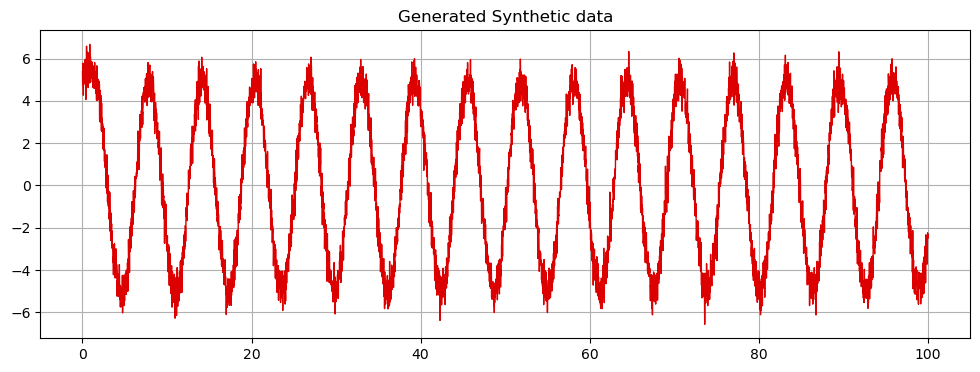

In [45]:
np.random.seed(0)
torch.manual_seed(0)
N = 5000
t = np.linspace(0, 100, N)
data = 5 * np.sin(t) + 0.5 * np.random.randn(N) + 4.5 * np.cos(t)*np.exp(-0.5*t)

plt.figure(figsize=(12, 4))
plt.title("Generated Synthetic data")
plt.plot(t, data, linewidth=1.0, color="#DD0000")
plt.grid(True)
plt.show()

## Example of converting into sequential data

* source: https://www.geeksforgeeks.org/long-short-term-memory-networks-using-pytorch/

In [46]:
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data)-seq_length):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 10
X, y = create_sequences(data, seq_length)
X_tensor = torch.tensor(X[:, :, None], dtype=torch.float32)
y_tensor = torch.tensor(y[:, None], dtype=torch.float32)

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

In [48]:
import os
# Create TensorDatasets
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# Create DataLoaders
batch_size = 64  

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=os.cpu_count(), shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, num_workers=os.cpu_count(), shuffle=False)

print(f"Dataloaders:\nTrain dataloader: {train_dataloader}\nTest dataloader: {test_dataloader}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {test_dataloader.batch_size}")
print(f"=============================================================================="*100)
print(f"Length of train dataloader: {len(train_dataloader)} batches of {train_dataloader.batch_size}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {test_dataloader.batch_size}")

Dataloaders:
Train dataloader: <torch.utils.data.dataloader.DataLoader object at 0x7facb932df70>
Test dataloader: <torch.utils.data.dataloader.DataLoader object at 0x7facb935f860>
Length of test dataloader: 16 batches of 64
Length of train dataloader: 63 batches of 64
Length of test dataloader: 16 batches of 64


# Models

## CNN-LSTM Hybrid Model

In [50]:
# cnn_params = [16, 32, "MaxPool"]
cnn_params = [8, "MaxPool"]
class CNN1D(nn.Module):
    def __init__(self, input):
        super(CNN1D, self).__init__()
        self.input = input
        self.conv_blocks = self.create_conv_blocks(cnn_params)
        
    def create_conv_blocks(self, architecture):
        layers = []
        input = self.input

        for x in architecture:
            if type(x) == int:
                output = x
                layers += [nn.Conv1d(input, output, 
                        kernel_size=2, stride=1, padding=0),
                        nn.BatchNorm1d(x),
                        nn.SiLU()]

                input = x  # Update input channels
            elif x == "MaxPool":
                layers += [nn.MaxPool1d(kernel_size=2, stride=1)]

        return nn.Sequential(*layers)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # (batch, features, time_steps) → (batch, channels, time_steps)
        x = self.conv_blocks(x)
        return x  # Output shape: (batch, channels, reduced_time_steps)

class MainModel(nn.Module):
    def __init__(self, input_size=5, hidden_size=100, num_layers=3, output_size=1):
        super(MainModel, self).__init__()
        self.num_layers = num_layers  
        self.hidden_size = hidden_size
        self.cnn = CNN1D(input_size)
        self.lstm = nn.LSTM(input_size=8, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, x: torch.Tensor, h0=None, c0=None):
        x = self.cnn(x)
        x = x.permute(0, 2, 1)  # (batch, channels, time) → (batch, time, channels)
        if h0 is None or c0 is None:
            h0 = torch.zeros(self.num_layers, x.size(0),self.hidden_size)
            c0 = torch.zeros(self.num_layers, x.size(0),self.hidden_size)
            # h0 = torch.randn(self.num_layers, x.size(0), self.hidden_size) * 0.02
            # c0 = torch.randn(self.num_layers, x.size(0), self.hidden_size) * 0.02
        x, _ = self.lstm(x, (h0, c0))
        x = x[:, -1, :]
        x = self.fc(x) 
        return x


## Vanilla LSTM

In [15]:
class MyModel(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(MyModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.SiLU(),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, x: torch.Tensor, h0=None, c0=None):
        ##initialize hidden state
        if h0 is None or c0 is None:
            h0 = torch.zeros(self.num_layers, x.size(0),self.hidden_size)
            c0 = torch.zeros(self.num_layers, x.size(0),self.hidden_size)
        x, _ = self.lstm(x, (h0, c0))
        x = x[:, -1, :]
        x = self.fc(x)
        return x

# Training 

## Initialize Parameters

In [51]:
from sklearn.metrics import r2_score
def calculate_accuracy(y_true, y_pred):
    """
    Computes an accuracy-like metric for regression using R^2 Score.
    """
    y_true = y_true.detach().cpu().numpy()
    y_pred = y_pred.detach().cpu().numpy()

    r2 = r2_score(y_true, y_pred)  # Best: 1, Worst: -∞
    return r2  # Treat as "accuracy" for regression

## Setup loss function
loss_fn = nn.MSELoss()

num_of_epochs = 100
num_loss_steps = 10
seed_number = 42
learning_rate = 0.001
device = "cpu"

## Define Training and Step Functions

In [52]:
def train(data_loader:torch.utils.data.DataLoader,
               model:torch.nn.Module,
               loss_fn:torch.nn.Module,
               optimizer:torch.optim.Optimizer,
               calculate_accuracy,
               device: torch.device = device,
               loss_steps: int = 100,
               seed: int = 25):
  # Set seed for reproducibility
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)

  #Training
  train_loss, train_acc = 0, 0
  #Put Data into training Mode
  model.train()
  # Initialize hidden and cell states
  for batch, (X, y) in enumerate(data_loader):
    X, y = X.to(device), y.to(device)
    y_pred = model(X)
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()
    train_acc += calculate_accuracy(y_true=y,
                             y_pred=y_pred)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss = train_loss / len(data_loader)
  train_acc = train_acc / len(data_loader)
  if epoch % loss_steps == 0:
    print(f"Training Loss: {train_loss:.5f} | Training R2: {train_acc:.4f}%")
  return train_loss, train_acc

def test(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              calculate_accuracy,
              device: torch.device = device,
              loss_steps: int = 100,
              seed: int = 42):
  # Set seed for reproducibility
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)

  #Testing
  test_loss, test_acc = 0, 0
  model.to(device)
  #Put Data into evaluation Mode
  model.eval()
  with torch.inference_mode():
    for X, y in data_loader:
      X,y = X.to(device), y.to(device)
      test_pred = model(X)
      loss = loss_fn(test_pred, y)
      test_loss += loss.item()
      test_acc += calculate_accuracy(y_true=y, y_pred=test_pred)

    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    if epoch % loss_steps == 0:
      print(f"Test Loss {test_loss:.5f} | Test R2 {test_acc:5f}%")
    return test_loss, test_acc

## Training Loop Part 1

In [53]:
np.random.seed(seed_number)
torch.manual_seed(seed_number)
torch.cuda.manual_seed_all(seed_number)

model = MainModel(input_size=1, 
                  hidden_size=4, num_layers=2, output_size=1).to(device)

optimizer = Adan(params=model.parameters(), 
                  lr=0.001, 
                  betas=(0.9, 0.92, 0.99), 
                  weight_decay=0.01)

# optimizer = Lion(params=model.parameters(), 
#                   lr=0.001, 
#                   betas=(0.9, 0.99), 
#                   weight_decay=1e-2)
results = {
    "train_loss": [],
    "train_accu": [],
    "test_loss": [],
    "test_accu": []
}

start_adan = time.perf_counter()
for epoch in tqdm(range(0, num_of_epochs)):
  if epoch % num_loss_steps == 0:
    print(f"Epoch: {epoch} \n =====================================================================")

  train_loss, train_accu = train(data_loader = train_dataloader,
                                  model = model,
                                  loss_fn = loss_fn,
                                  optimizer = optimizer,
                                  calculate_accuracy = calculate_accuracy,
                                  device = device,
                                  loss_steps = num_loss_steps,
                                  seed = seed_number);

  test_loss, test_accu = test(data_loader = test_dataloader,
                              model = model,
                              loss_fn = loss_fn,
                              calculate_accuracy = calculate_accuracy,
                              device = device,
                              loss_steps = num_loss_steps,
                              seed=seed_number);

  results["train_loss"].append(train_loss)
  results["train_accu"].append(train_accu)
  results["test_loss"].append(test_loss)
  results["test_accu"].append(test_accu)
  
end_adan = time.perf_counter()
total_time_adan = end_adan - start_adan
print(f"Total Runtime: {total_time_adan / 60: .2f}")

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0 
Training Loss: 13.25763 | Training R2: -0.0349%
Test Loss 13.06177 | Test R2 -0.035097%
Epoch: 10 
Training Loss: 2.35768 | Training R2: 0.8162%
Test Loss 2.02473 | Test R2 0.840646%
Epoch: 20 
Training Loss: 0.63833 | Training R2: 0.9496%
Test Loss 0.48949 | Test R2 0.961177%
Epoch: 30 
Training Loss: 0.56509 | Training R2: 0.9554%
Test Loss 0.39929 | Test R2 0.968198%
Epoch: 40 
Training Loss: 0.55044 | Training R2: 0.9565%
Test Loss 0.37614 | Test R2 0.970030%
Epoch: 50 
Training Loss: 0.54363 | Training R2: 0.9571%
Test Loss 0.36476 | Test R2 0.970933%
Epoch: 60 
Training Loss: 0.53918 | Training R2: 0.9575%
Test Loss 0.35842 | Test R2 0.971430%
Epoch: 70 
Training Loss: 0.53572 | Training R2: 0.9577%
Test Loss 0.35406 | Test R2 0.971770%
Epoch: 80 
Training Loss: 0.53301 | Training R2: 0.9580%
Test Loss 0.35084 | Test R2 0.972020%
Epoch: 90 
Training Loss: 0.53088 | Training R2: 0.9581%
Test Loss 0.34840 | Test R2 0.972212%
Total Runtime:  1.36


In [ ]:
device = "cpu"
np.random.seed(seed_number)
torch.manual_seed(seed_number)
torch.cuda.manual_seed_all(seed_number)

model_Adan2 = MyModel(input_size=1,
                      hidden_size=50, 
                      num_layers=2, 
                      output_size=1).to(device)

optimizer_Adan2 = Adan(params=model_Adan2.parameters(), 
                      lr=learning_rate, 
                      betas=(0.94, 0.91, 0.95), 
                      weight_decay=0.01)

results1 = {
    "train_loss": [],
    "train_accu": [],
    "test_loss": [],
    "test_accu": []
}

start_adan = time.perf_counter()
for epoch in tqdm(range(0, num_of_epochs)):
  if epoch % num_loss_steps == 0:
    print(f"Epoch: {epoch} \n =====================================================================")

  train_loss, train_accu = train(data_loader = train_dataloader,
                                  model = model_Adan2,
                                  loss_fn = loss_fn,
                                  optimizer = optimizer_Adan2,
                                  calculate_accuracy = calculate_accuracy,
                                  device = device,
                                  loss_steps = num_loss_steps,
                                  seed = seed_number);

  test_loss, test_accu = test(data_loader = test_dataloader,
                              model = model_Adan2,
                              loss_fn = loss_fn,
                              calculate_accuracy = calculate_accuracy,
                              device = device,
                              loss_steps = num_loss_steps,
                              seed=seed_number);

  results1["train_loss"].append(train_loss)
  results1["train_accu"].append(train_accu)
  results1["test_loss"].append(test_loss)
  results1["test_accu"].append(test_accu)
  
end_adan = time.perf_counter()
total_time_adan = end_adan - start_adan
print(f"Total Runtime: {total_time_adan / 60: .2f}")

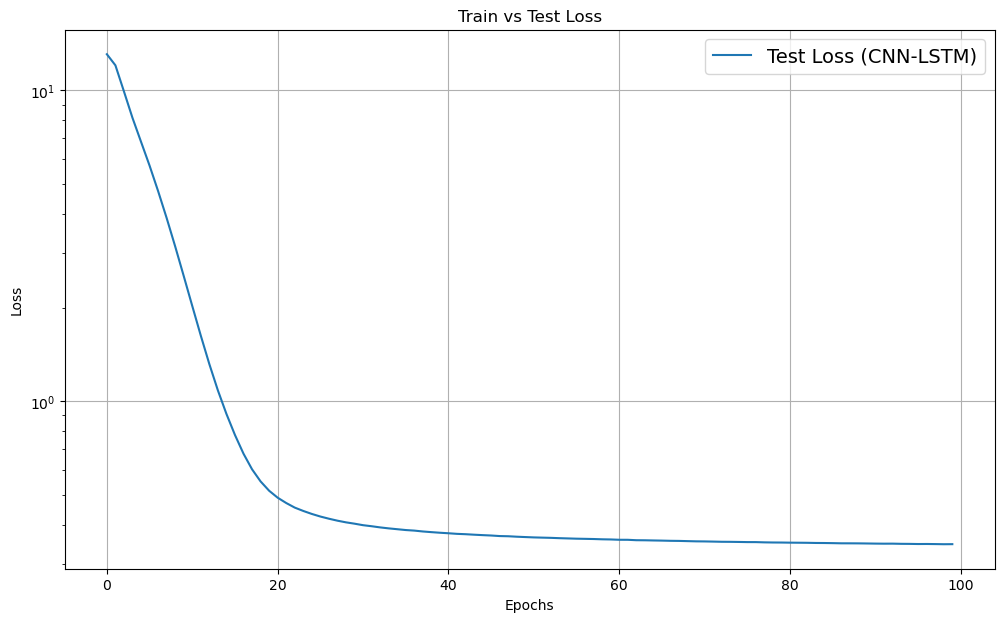

In [54]:
plt.figure(figsize=(12, 7))
# plt.plot(results["train_loss"], label="Train Loss")
plt.semilogy(results["test_loss"], label="Test Loss (CNN-LSTM)")
# plt.plot(results1["test_loss"], label="Test Loss (LSTM)")
plt.title("Train vs Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc="upper right", fontsize=14)
plt.grid(True)
plt.show()

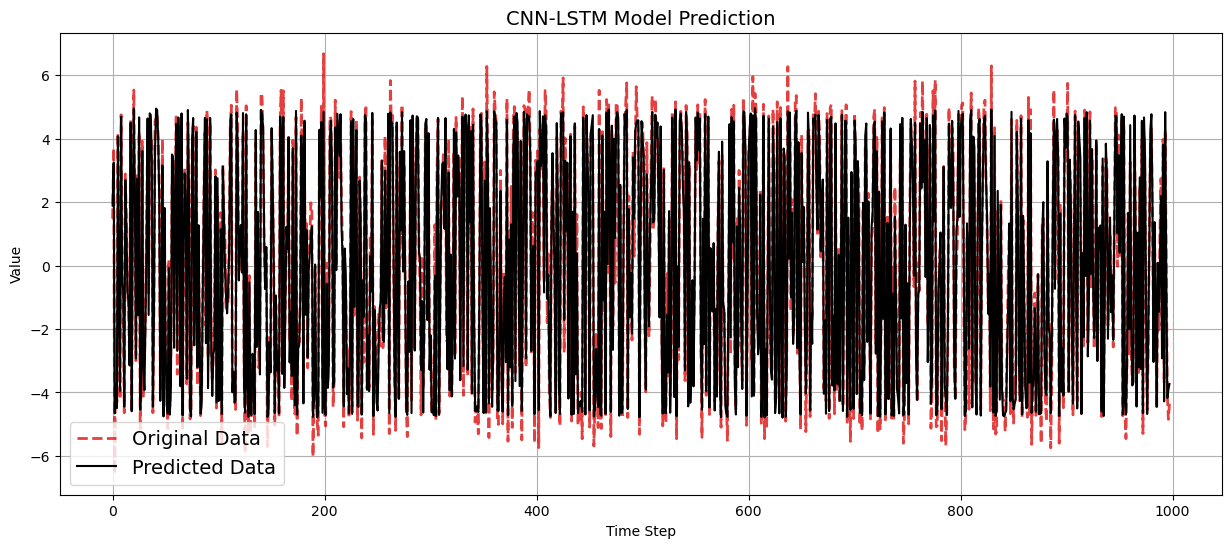

In [57]:
# Make sure the model is in evaluation mode
model.eval()
device="cpu"

with torch.no_grad(): 
    predicted = model(X_test)  # Pass the input through the model


# Flatten the predictions and true values to 1D
predicted = predicted.cpu().numpy().reshape(-1,1)  # Convert (188, 10, 1) -> (1880,)
original = y_test.reshape(-1,1)  # Convert (188, 10, 1) -> (1880,)


# Plotting the results
plt.figure(figsize=(15, 6))
plt.plot(original, label='Original Data', linestyle='--', linewidth=2.0, color="#DD0000", alpha=0.75)
plt.plot(predicted, label='Predicted Data', linestyle='-', linewidth=1.5, color="#000000")
plt.title('CNN-LSTM Model Prediction', fontsize=14)
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend(fontsize=14, loc="lower left")
plt.grid(True)
plt.show()
